## 라이브러리 불러오기

In [1]:
import datetime

import requests
from lxml import html

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, precision_score, roc_curve, f1_score, confusion_matrix, r2_score

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.simplefilter('ignore')


## 크롤링

In [2]:
url = "https://www.weather.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}
response = requests.request("GET", url, headers=headers)
tree = html.fromstring(response.content)

In [3]:
locations = tree.xpath('//location')
res = []
k = 0
for loc in locations:
    c = loc.xpath('.//city/text()')[0]
    data = loc.xpath('.//data')
    k += 1
    for d in data:
        t = str(d.xpath('.//tmef/text()')[0])
        s = d.xpath('.//wf/text()')[0]
        m = d.xpath('.//tmn/text()')[0]
        M = d.xpath('.//tmx/text()')[0]
        res.append([c, t, s, m, M])
df = pd.DataFrame(res, columns=['도시', '날짜','날씨', '최저', '최고'])
df.head()

,도시,날짜,날씨,최저,최고
0,서울,2021-07-28 00:00,맑음,26,34
1,서울,2021-07-28 12:00,맑음,26,34
2,서울,2021-07-29 00:00,맑음,25,34
3,서울,2021-07-29 12:00,구름많음,25,34
4,서울,2021-07-30 00:00,구름많음,26,34


## 데이터 확인

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   도시      455 non-null    object
 1   날짜      455 non-null    object
 2   날씨      455 non-null    object
 3   최저      455 non-null    object
 4   최고      455 non-null    object
dtypes: object(5)
memory usage: 17.9+ KB


## 데이터 타입 변경

In [5]:
df['최저'] = df['최저'].astype(np.int32)
df['최고'] = df['최고'].astype(np.int32)

In [6]:
df['날짜'] = pd.to_datetime(df['날짜'])

In [7]:
df['월'] = df['날짜'].dt.month
df['일'] = df['날짜'].dt.day
df['시'] = df['날짜'].dt.hour

## 문제1. 날씨 예측
* Feature : 도시, 최고, 최저

In [8]:
x_data, y_data = df[['도시', '최저', '최고']], df[['날씨']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1, stratify=y_data)


In [9]:
ct = ColumnTransformer([('ohe',OneHotEncoder(sparse=False) ,['도시']),
                        ('scaler', StandardScaler(), ['최저', '최고'])])
model = make_pipeline(ct, LogisticRegression())
param_grid = {'logisticregression__C': np.linspace(0,1, 20),
               'logisticregression__penalty':['l1', 'l2', 'elasticnet', 'none']
              , 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(model, param_grid = param_grid, scoring='f1_macro')
grid.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['도시']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['최저',
                                                                          '최고'])])),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.5789

In [10]:
grid.best_score_

0.34667830675648514

In [11]:
y_pred = grid.best_estimator_.predict(x_test)
print('test f1-score : ', f1_score(y_test, y_pred, average='macro'))

test f1-score :  0.32962222856599105


* Feature : 도시, 최고, 최저 + [월, 일, 시] (위의 3개 Feature 도시, 최고, 최저 성능이 안좋아서 추가해봄)

In [12]:
x_data, y_data = df[['도시', '최저', '최고', '월', '일', '시']], df[['날씨']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1, stratify=y_data)

In [13]:
ct = ColumnTransformer([('ohe',OneHotEncoder(sparse=False) ,['도시']),
                        ('scaler', StandardScaler(), ['최저', '최고', '월','일','시'])])
model = make_pipeline(ct, LogisticRegression())
param_grid = {'logisticregression__C': np.linspace(0,1, 20),
               'logisticregression__penalty':['l1', 'l2', 'elasticnet', 'none']
              , 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(model, param_grid = param_grid, scoring='f1_macro')
grid.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['도시']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['최저',
                                                                          '최고',
                                                                          '월',
                                                                          '일',
                                                                          '시'])])),
                                       ('logisticregression',
                                     

In [14]:
grid.best_score_

0.6596018617363619

In [15]:
y_pred = grid.best_estimator_.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.723952395239524

## 문제2. 다음날의 최고 최저 예측
* 데이터의 마지막날인 2021-08-04 00:00:00 데이터(test data로 설정)

In [16]:
last = df.sort_values('날짜').tail(1)['날짜'].iloc[0]
test = df.loc[df['날짜']==last]
train = df.loc[df['날짜']!=last]

In [17]:
x_train, y_train = train[['도시', '날씨', '월', '일', '시']], train[['최저', '최고']]
x_test, y_test = test[['도시', '날씨', '월', '일', '시']], test[['최저', '최고']]

In [18]:
ct = ColumnTransformer([('ohe',OneHotEncoder(sparse=False) ,['도시', '날씨']),
                        ('scaler', StandardScaler(), ['월', '일', '시'])])
model  = make_pipeline(ct, ElasticNet())
param_grid = {'elasticnet__alpha':[0, 0.001, 0.01,0.05,0.1, 0.25, 0.5, 0.75, 1, 2, 3, 4, 5], 
             'elasticnet__l1_ratio':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
grid = GridSearchCV(model, param_grid=param_grid, cv=5, verbose=1)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 143 candidates, totalling 715 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['도시',
                                                                          '날씨']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['월',
                                                                          '일',
                                                                          '시'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid={'elasticnet__alpha': [0, 0.001, 0.01, 0.05, 0.1, 0.25,
         

In [19]:
grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(sparse=False),
                                                  ['도시', '날씨']),
                                                 ('scaler', StandardScaler(),
                                                  ['월', '일', '시'])])),
                ('elasticnet', ElasticNet(alpha=0, l1_ratio=0))])

In [20]:
y_pred = grid.best_estimator_.predict(x_train)
print('train r2 :', r2_score(y_train, y_pred))

train r2 : 0.8336747839246303


In [21]:
y_pred = grid.best_estimator_.predict(x_test)
print('test r2 :',r2_score(y_test, y_pred))

test r2 : 0.45496917463965975


In [22]:
print('===============예측 결과===============')
print(y_pred)

===============예측 결과===============
[[26.19775145 33.94040919]
 [26.36441812 31.94040919]
 [25.36441812 34.02374253]
 [24.36441812 33.85707586]
 [24.53108479 34.10707586]
 [25.19775145 33.52374253]
 [23.36441812 28.44040919]
 [24.36441812 33.27374253]
 [26.28108479 33.85707586]
 [23.94775145 31.60707586]
 [25.36441812 32.35707586]
 [24.86441812 33.44040919]
 [24.94775145 33.94040919]
 [25.28108479 32.60707586]
 [24.03108479 32.77374253]
 [24.36441812 33.35707586]
 [23.86441812 32.60707586]
 [23.86441812 32.77374253]
 [22.53108479 32.94040919]
 [23.61441812 32.27374253]
 [22.69775145 33.19040919]
 [25.44775145 33.44040919]
 [24.03108479 32.77374253]
 [24.03108479 32.69040919]
 [25.03108479 33.44040919]
 [25.28108479 33.52374253]
 [24.36441812 33.60707586]
 [25.36441812 32.69040919]
 [24.86441812 33.27374253]
 [23.78108479 32.94040919]
 [25.28108479 33.85707586]
 [24.28108479 32.60707586]
 [23.53108479 32.10707586]
 [23.86441812 32.44040919]
 [23.53108479 31.94040919]]


# 추가 통계값

## 문제3. 지역 별 기온 차이의 평균

In [23]:
df['기온차'] = df['최고'] - df['최저']

In [24]:
기온차 = df.groupby(['도시','시'])[['기온차']].mean()
기온차_12 = 기온차.query('시==12').sort_values('기온차', ascending=False).reset_index()
기온차_00 = 기온차.query('시==00').sort_values('기온차', ascending=False).reset_index()

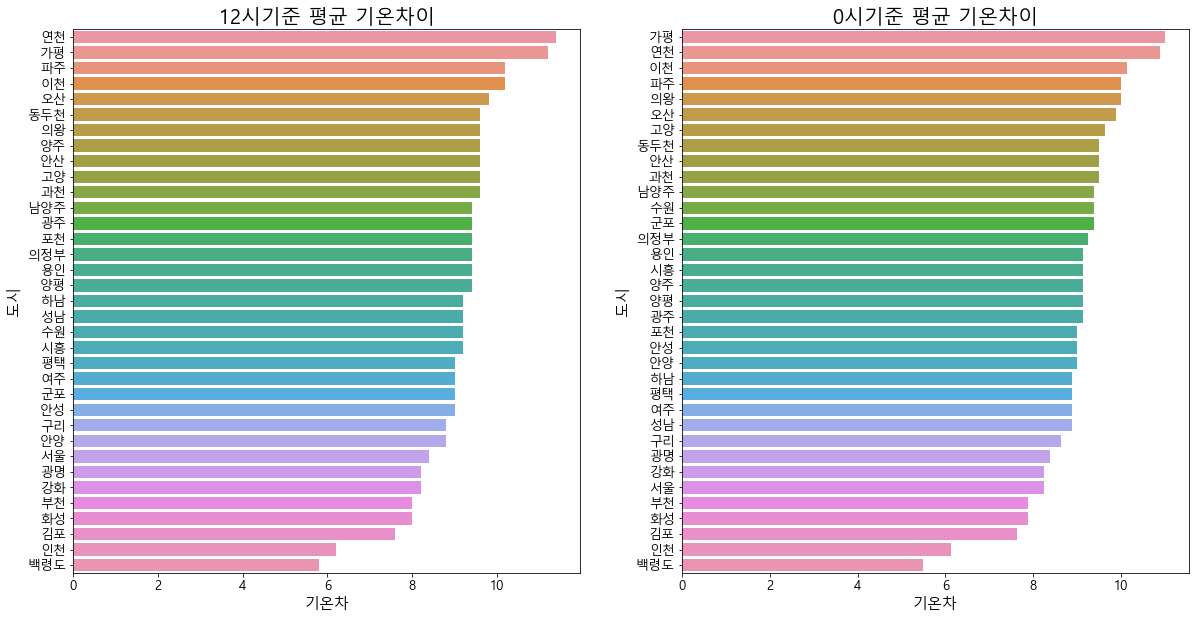

In [27]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1,2,1)
sns.barplot(data=기온차_12, y='도시', x='기온차')
plt.xlabel('기온차', fontsize=15)
plt.ylabel('도시', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('12시기준 평균 기온차이', fontsize=20)

fig.add_subplot(1,2,2)
sns.barplot(data=기온차_00, y='도시', x='기온차')
plt.xlabel('기온차', fontsize=15)
plt.ylabel('도시', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('0시기준 평균 기온차이', fontsize=20)

plt.show()

## 문제4. 위에서 상위에 있는 가평, 연천의 온도 변화

In [28]:
가평 = df.query('도시=="가평"').sort_values(['날짜']).set_index('날짜')
연천 = df.query('도시=="연천"').sort_values(['날짜']).set_index('날짜')

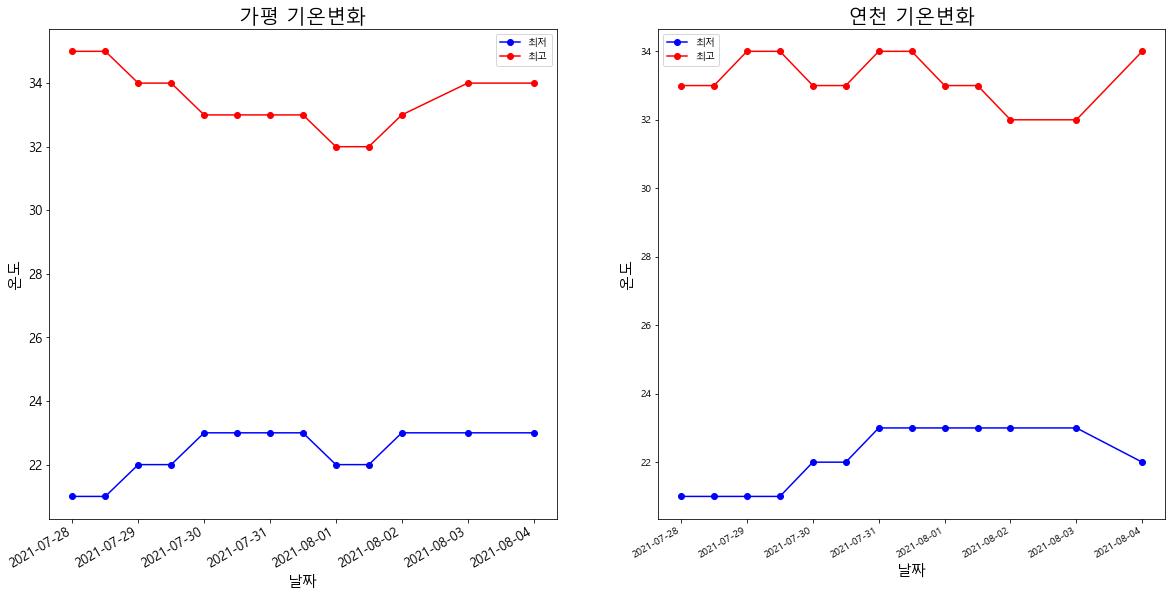

In [29]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1,2,1)
가평['최저'].plot(kind='line', style=['bo-'])
가평['최고'].plot(kind='line', style=['ro-'])
plt.xlabel('날짜', fontsize=15)
plt.ylabel('온도', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('가평 기온변화', fontsize=20)
plt.legend()

fig.add_subplot(1,2,2)
연천['최저'].plot(kind='line', style=['bo-'])
연천['최고'].plot(kind='line',style=['ro-'])
plt.xlabel('날짜', fontsize=15)
plt.ylabel('온도', fontsize=15)
plt.title('연천 기온변화', fontsize=20)
plt.legend()

plt.show()

## 문제5. 지역별 날씨 분포

In [30]:
df_by_도시 = df.groupby(['도시'])['날씨']

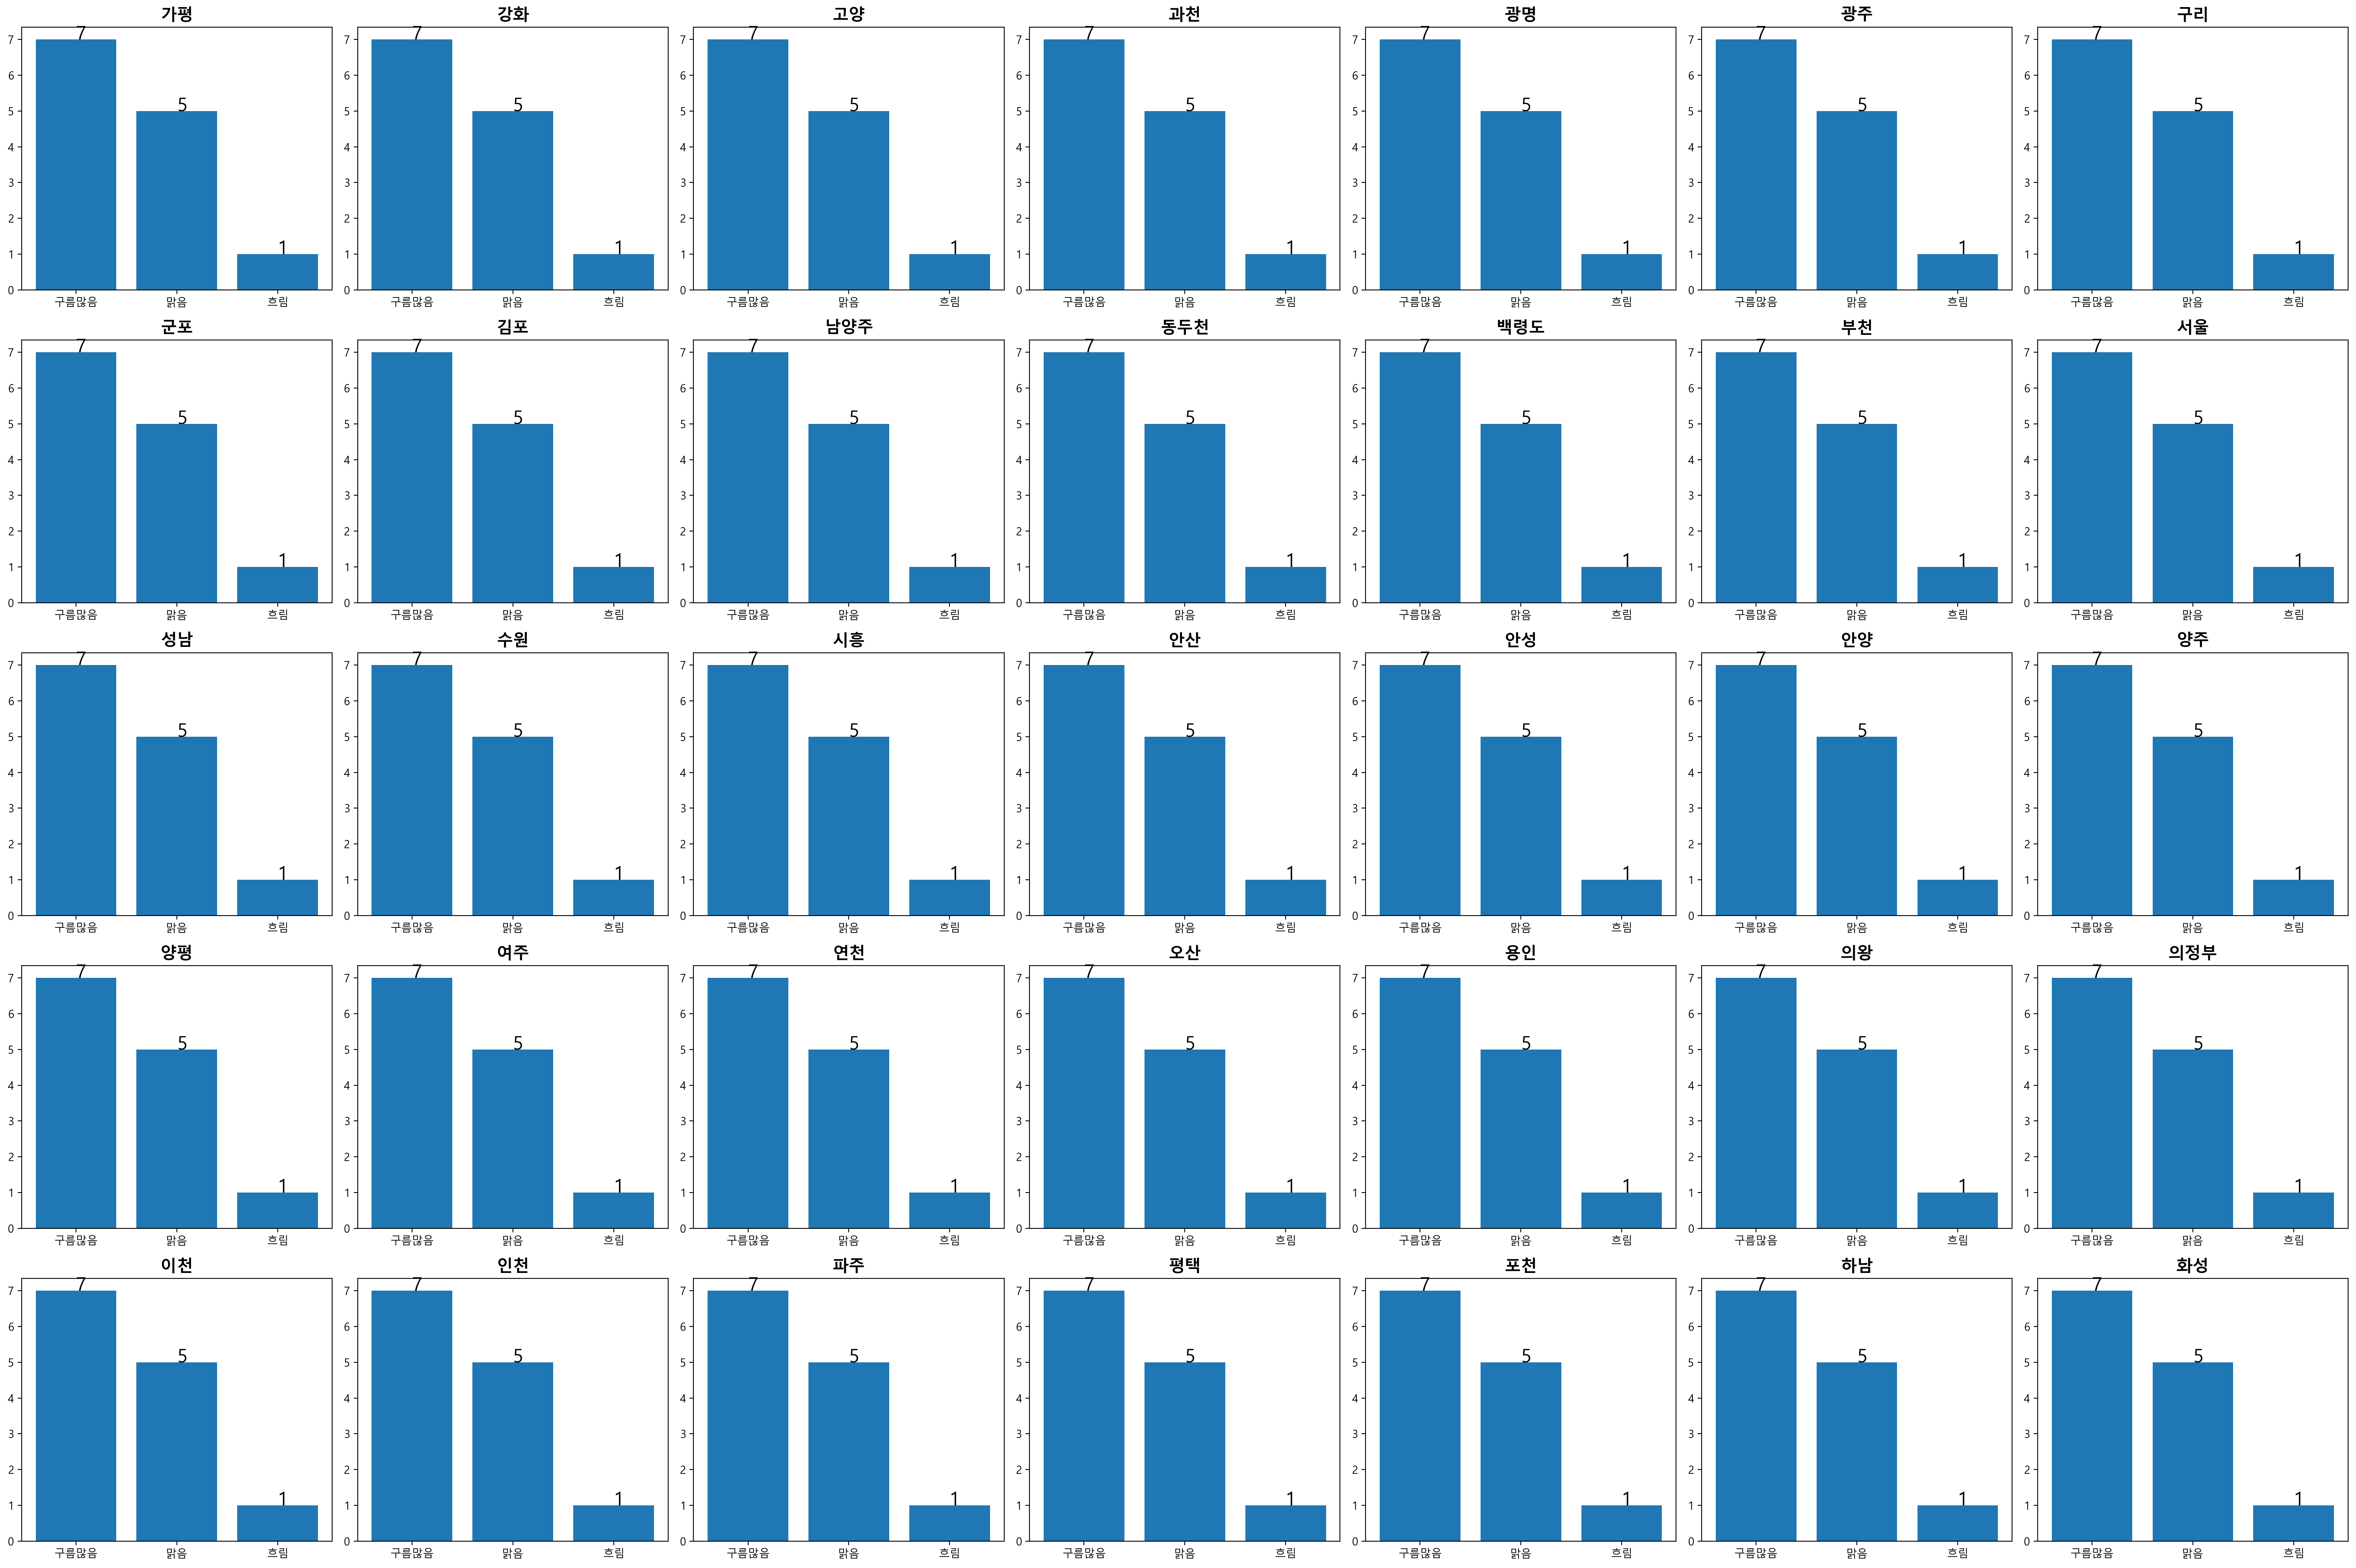

In [31]:
fig, ax = plt.subplots(5, 7, figsize=(30,20), dpi=200)
for (city, s_tmp), ax in zip(df_by_도시, ax.flatten()):
    
    tmp_cnt = s_tmp.value_counts()
#     print(tmp_cnt)
    ax.bar(tmp_cnt.index, tmp_cnt)
    ax.text('맑음', tmp_cnt['맑음'], tmp_cnt['맑음'], fontsize='xx-large')
    ax.text('흐림', tmp_cnt['흐림'], tmp_cnt['흐림'] ,fontsize='xx-large')

    ax.text('구름많음', tmp_cnt['구름많음'], tmp_cnt['구름많음'] ,fontsize='xx-large')
    ax.set_title(city, fontweight='bold', fontsize=15)
fig.tight_layout()
plt.show()

* 모든 도시에서 구름많음, 맑음, 흐림 개수가 같음